<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/LongShortCointegra%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import yfinance as yf

import numpy as np
import pandas as pd

import seaborn
from seaborn.matrix import axis_ticklabels_overlap
import matplotlib.pyplot as plt
from pylab import rcParams
#rcParams['figure.figsize'] = 15, 5

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [101]:
symbols = [
    'RRRP3', 'ENEV3','PETR3', 'PETR4', 'PRIO3',
    'ABEV3', 'ASAI3','CRFB3','LREN3', 'MGLU3','PCAR3', 'VIIA3',
    'AZUL4', 'GOLL4', 'CVCB3',
    'B3SA3', 'BPAN4','BPAC11', 'BBSE3','BBDC3', 'BBDC4', 'BBAS3', 'CIEL3','ITSA4','ITUB4', 'SANB11',
    'IGTI11','MULT3',
    'BRAP4', 'CMIN3', 'GGBR4', 'GOAU4','CSNA3','USIM5','VALE3',
    'BRFS3', 'JBSS3', 'MRFG3', 'BEEF3',
    'CCRO3', 'ECOR3',
    'CMIG4', 'CPLE6', 'CPFE3', 'ELET3', 'ELET6', 'ENGI11','EGIE3', 'EQTL3','TAEE11',
    'CYRE3', 'DXCO3', 'EZTC3','JHSF3','MRVE3',
    'HAPV3', 'HYPE3', 'QUAL3', 'RADL3', 'RDOR3',
    'LWSA3', 'POSI3', 'TOTS3','SQIA3' , 'VLID3' ,
    'UGPA3', 'VBBR3', 
    'BOVA11', 'SMAL11'
    ] 

dados = yf.download((pd.Series(symbols)+'.SA').to_list(), period = 'max', auto_adjust=True , progress = False)['Close']
dados.dropna(inplace=True)
print(dados.shape[0])

symbols=dados.keys()

N=int(len(symbols)*(len(symbols)-1)/2)
print(N)
relative_cutoff = 1 * 10 ** (-int(np.log(N)/np.log(10))-1)
print(relative_cutoff)

436
2346
0.0001


In [103]:
dados.to_csv('/home/yair/GHub/Codigos-em-financas/precos.csv')
dados.head()

,ABEV3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BOVA11.SA,...,SMAL11.SA,SQIA3.SA,TAEE11.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VLID3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-22,15.835101,13.597360,27.200001,11.266340,25.165943,14.238089,16.624496,18.276424,7.873819,98.239998,...,114.000000,16.876842,29.377354,32.322639,12.415503,11.268918,58.578014,20.638178,5.71,7.321340
2021-11-23,15.725390,13.666382,26.900000,11.154606,26.218138,14.590761,16.945787,18.025145,8.163432,100.000000,...,113.000000,16.489668,29.319300,30.711390,13.034872,11.805108,60.120689,21.224863,5.92,7.476337
2021-11-24,15.633963,13.528338,26.559999,11.350139,26.703823,14.853213,17.382402,18.117281,8.063878,100.660004,...,113.300003,16.231552,29.651064,31.365654,12.987949,12.216187,61.516014,20.912596,5.87,7.476337
2021-11-25,15.752815,13.656522,27.150000,11.517735,28.090229,14.910622,17.522448,18.536081,8.091029,101.989998,...,115.370003,16.817278,29.841818,31.629313,13.269482,12.350235,61.100010,21.073460,5.95,7.631335
2021-11-26,15.259113,13.173367,23.299999,10.968388,27.163017,14.385716,16.822212,18.033524,7.873819,98.389999,...,110.699997,16.082640,29.725708,30.594208,12.800262,11.537013,59.488014,20.505701,5.68,7.394280


In [96]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def residuos (x,y):
  x = np.array(x)
  y = np.array(y)
  xx = sm.add_constant(x)
  model = sm.OLS(y, xx)
  results = model.fit()
  intercept, slope = results.params
  r_sq = results.rsquared 
  return y -  slope*x , slope , intercept , r_sq 

def estacionaridade(X, cutoff=0.01 ):
     # H_0 é nao-estacionário, i.e., admite raiz unitaria (teste adfuller)    
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' A serie "'+X.name+'" é, provavelmente, estacionaria.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' A serie "'+X.name+'" é, provavelmente, não-estacionaria.')
        return False

def find_cointegrated_pairs(data,cutoff=0.05):
  """
      Para cada par (X,Y) de ativos testa cointegração. ie, estacionariedade de Y - Ŷ  
  """
  n = data.shape[1]
  score_matrix = np.zeros((n, n))
  pvalue_matrix = np.ones((n, n))
  keys = data.keys()
  pairs = []
  for i in range(n):
      for j in range(i+1, n):
          X = data[keys[i]]
          Y = data[keys[j]]
          result = coint(Y,X) # Y dependent
          score = result[0]
          pvalue = result[1]
          score_matrix[i, j] = score
          pvalue_matrix[i, j] = pvalue
          if pvalue < cutoff:
              pairs.append((keys[i], keys[j]))
  return score_matrix, pvalue_matrix, pairs 


def arrange_subplots(xs, ys, n_plots , tt =[]):
  """
  ---- Parameters ----
  xs (n_plots, d): list with n_plot different lists of x values that we wish to plot
  ys (n_plots, d): list with n_plot different lists of y values that we wish to plot
  n_plots (int): the number of desired subplots
  """
  from matplotlib import gridspec
  %matplotlib inline

  # compute the number of rows and columns
  if n_plots<3 : 
    n_cols = 3
    n_rows = 1
  else: 
    n_cols = int(np.sqrt(n_plots))
    n_rows = int(np.ceil(n_plots / n_cols))

  # setup the plot
  gs = gridspec.GridSpec(n_rows, n_cols)
  scale = max(n_cols, n_rows)
  fig = plt.figure(figsize=(.5 * scale, .5 * scale))

  # loop through each subplot and plot values there
  for i in range(n_plots):
    ax = fig.add_subplot(gs[i])
    ax.title.set_text(tt[i])
    ax.plot(xs[i], ys[i])
    plt.axhline(y = 0, color = 'silver', linestyle = '-')
    plt.axhline(y = 1, color = 'orange', linestyle = '-')
    plt.axhline(y = -1, color = 'orange', linestyle = '-')
    plt.axhline(y = 2, color = 'red', linestyle = '-')
    plt.axhline(y = -2, color = 'red', linestyle = '-')

    plt.show()



In [ ]:
# # code to check data
# y = dados.iloc[:,0].values.astype(float)
# x = dados.iloc[:,1].values.astype(float)
# print(coint(x,y))
# print(coint(y,x))
# xx = sm.add_constant(x)
# model = sm.OLS(y, xx)
# result = model.fit()
# intercept, slope = result.params
# print(adfuller(y-slope*x))
# print(adfuller(y-(slope*x+intercept)))
# print(adfuller(result.resid))

In [116]:
scores, pvalues, pairs = find_cointegrated_pairs(dados,.005)#relative_cutoff)
len(pairs)

14

In [117]:
for pp in pairs:
    i = pd.Index(symbols).get_loc(pp[0])
    j = pd.Index(symbols).get_loc(pp[1])
    if (1-pvalues[i,j]) > 0.999:
        print(f' par {pp}; confiabilidade {(1-pvalues[i,j])*100:.2f}%; score {scores[i,j]}; p-valor {pvalues[i,j]} ')

 par ('B3SA3.SA', 'BOVA11.SA'); confiabilidade 99.99%; score -5.21874809687291; p-valor 6.393445092095531e-05 
 par ('BPAC11.SA', 'ENGI11.SA'); confiabilidade 99.99%; score -5.054578451748146; p-valor 0.00013051168749976226 
 par ('BRAP4.SA', 'VALE3.SA'); confiabilidade 100.00%; score -9.062749904746234; p-valor 6.016518686850081e-14 
 par ('DXCO3.SA', 'GOLL4.SA'); confiabilidade 99.97%; score -4.8912060215547655; p-valor 0.00025964547229877417 
 par ('EGIE3.SA', 'IGTI11.SA'); confiabilidade 99.91%; score -4.580151392398768; p-valor 0.0009015229753899015 
 par ('MRFG3.SA', 'QUAL3.SA'); confiabilidade 99.94%; score -4.702595555484081; p-valor 0.000558099799035644 
 par ('RDOR3.SA', 'VBBR3.SA'); confiabilidade 99.97%; score -4.897326046537387; p-valor 0.0002531448359034276 


In [122]:
# dados = dados.apply(np.log)

In [123]:
pvalues.min()

6.016518686850081e-14

In [124]:
scores[np.unravel_index(scores.argmin(), scores.shape)[0]][np.unravel_index(scores.argmin(), scores.shape)[1]]

-9.062749904746234

In [125]:
print(symbols[np.unravel_index(pvalues.argmin(), pvalues.shape)[0]] 
      , symbols[np.unravel_index(pvalues.argmin(), pvalues.shape)[1]])

BRAP4.SA VALE3.SA


In [137]:
X= dados[symbols[np.unravel_index(scores.argmin(), scores.shape)[0]]]
Y= dados[symbols[np.unravel_index(scores.argmin(), scores.shape)[1]]]
X=dados['BPAC11.SA']
Y=dados['ENGI11.SA']

In [ ]:
# seaborn.set(rc={'figure.figsize':(8,8)})
# seaborn.heatmap(
#     pvalues, 
#     xticklabels=symbols, 
#     yticklabels=symbols, 
#     cmap='RdYlGn_r', 
#     mask = (pvalues >= 0.01)
# )

In [140]:
# !pip install -qU kaleido
import kaleido
import plotly
plotly.io.renderers.default = 'svg'


In [141]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


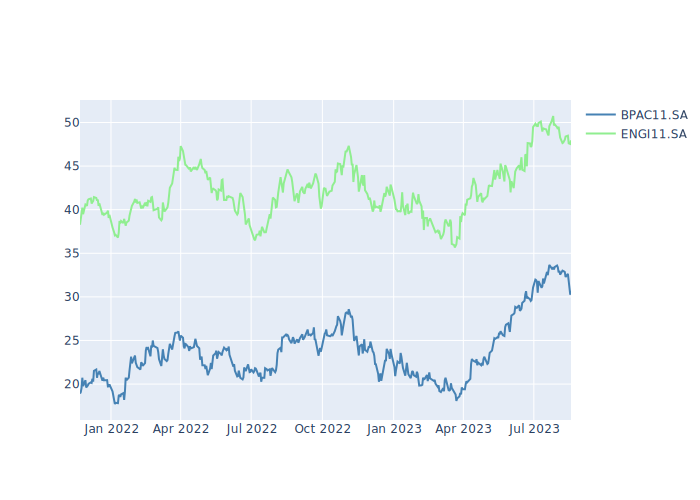

In [142]:
trace1 = go.Scatter( x = X.index,  y = X ,
                    name = X.name,
                    line=dict(color='steelblue'))

trace2 = go.Scatter( x = Y.index,  y = Y ,
                    name = Y.name , 
                    line=dict(color='lightgreen'))

fig = go.Figure(data=[trace1,trace2] )

fig.show()

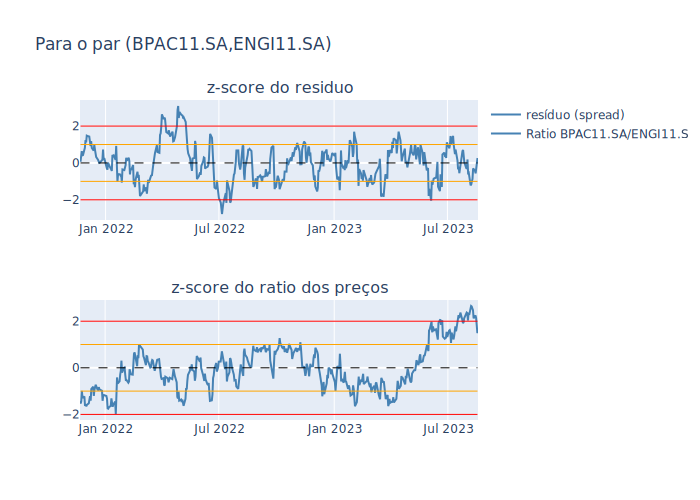

In [143]:


trace1 = go.Scatter( x = X.index,  y= zscore(residuos(x=X,y=Y)[0]) , 
                    name = 'resíduo (spread)',
                    line=dict(color='steelblue'))

trace2 = go.Scatter( x = Y.index,  y = zscore(X/Y) , 
                    name = 'Ratio '+X.name+'/'+Y.name,
                    line=dict(color='steelblue'))

fig = make_subplots(rows=2, cols=1,subplot_titles=(['z-score do residuo','z-score do ratio dos preços']))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(shapes=[{'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}}
                             ],title='Para o par ('+X.name+','+Y.name+')')
fig.show()

In [ ]:
trades = pd.concat([zscore(X/Y), residuos(x=X,y=Y)[0]], axis=1)
trades.columns = ["sinal", "posicao"]

trades["acao"] = 0
trades.loc[trades.sinal <-1, "acao"] = 1  # compra par
trades.loc[trades.sinal > 1, "acao"] = -1  # vende par
trades

In [ ]:
trades['pos1'] = trades['acao'].diff()
trades['oaca'] = -trades['acao']
trades['pos2'] = trades['oaca'].diff()
trades

In [ ]:
C0 = 1000

CX = C0 // max(X)
CY =  C0 //max(Y)

portfolio = pd.DataFrame()

portfolio[X.name] = X
portfolio['Hold'+X.name] 

portfolio[Y.name] = Y



<AxesSubplot:xlabel='Date'>

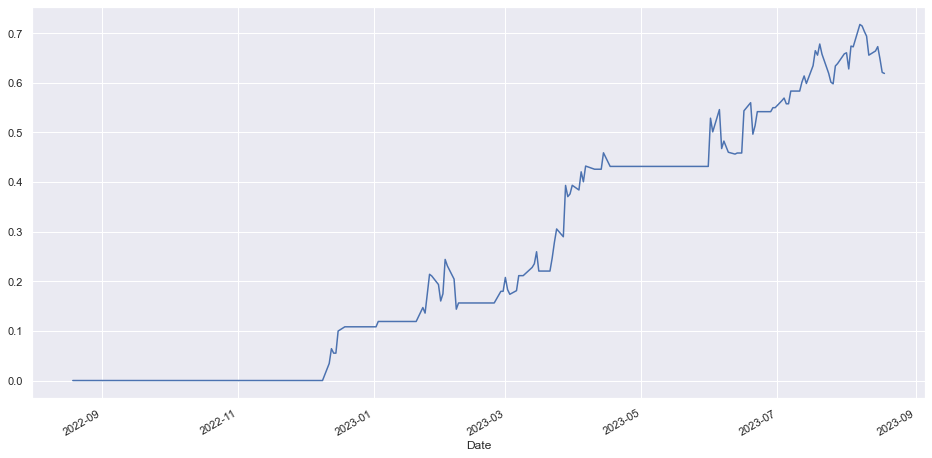

In [ ]:
retornos = trades.posicao.pct_change() * trades.acao
retornos.cumsum().plot(figsize=(16,8))